In [230]:
from IPython.display import Image, display

from openai import OpenAI
from dotenv import load_dotenv
load_dotenv()

True

In [231]:
class DemoAgent:
    def __init__(self,name: str,description: str):
        self.name = name
        self.description = description
        self.client = OpenAI()

    def chat(self, messages: list|str):
        if isinstance(messages, str):
            messages = [{"role": "user", "content": messages}]
        response = self.client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[{"role": "system", "content": self.description}] + messages,
            )
        return [{"role": "assistant", "content": response.choices[0].message.content,"sender": self.name}]

In [232]:
manger = DemoAgent(name="manger", description="You are a manger who can choose the best agent for the user.")

scientist = DemoAgent(name="scientist", description="You are a scientist who can answer questions about science.")
artist = DemoAgent(name="artist", description="You are an artist who can answer questions about art.")
mathmatician = DemoAgent(name="mathmatician", description="You are a mathmatician who can answer questions about math.")
psychologist = DemoAgent(name="psychologist", description="You are a psychologist who can answer questions about psychology.")

calculus_expert = DemoAgent(name="calculus_expert", description="You are a calculus expert who can answer questions about calculus.")
linear_algebra_expert = DemoAgent(name="linear_algebra_expert", description="You are a linear algebra expert who can answer questions about linear algebra.")
statistics_expert = DemoAgent(name="statistics_expert", description="You are a statistics expert who can answer questions about statistics.")

agents = {
    "manger": manger,
    "scientist": scientist,
    "artist": artist,
    "mathmatician": mathmatician,
    "psychologist": psychologist,
    "calculus_expert": calculus_expert,
    "linear_algebra_expert": linear_algebra_expert,
    "statistics_expert": statistics_expert
}

def call_agent(name: str, messages: list|str):
    print(f"Calling agent {name} to chat, this agent can be deployed anywhere")
    if name in agents:
        return agents[name].chat(messages)
    else:
        raise ValueError(f"Agent with name {name} not found")


In [233]:
from dataclasses import dataclass
from typing import List, Optional

@dataclass
class AgentSchema:
    name: str
    transfer_to_me_description: str = ""
    relations: Optional[List[str]] = None
    as_entry: Optional[bool] = False

In [244]:
manger_schema = AgentSchema(name="manger",
                            transfer_to_me_description="Call me if you don't know who to transfer the user to.",
                            relations=["scientist","artist","mathmatician","psychologist"],
                            as_entry=True)

scientist_schema = AgentSchema(name="scientist",
                              transfer_to_me_description="Call me if you have any questions about science.",
                              relations=["manger"])

artist_schema = AgentSchema(name="artist",
                            transfer_to_me_description="Call me if you have any questions about art.",
                            relations=["manger"])


psychologist_schema = AgentSchema(name="psychologist",
                            transfer_to_me_description="Call me if you have any questions about psychology or your current mental state needs help.",
                            relations=["manger"])

mathmatician_schema = AgentSchema(name="mathmatician",
                            transfer_to_me_description="Call me if you have any questions about math.",
                            relations=["manger","calculus_expert","linear_algebra_expert","statistics_expert"])

calculus_expert_schema = AgentSchema(name="calculus_expert",
                            transfer_to_me_description="Call me if you have any questions about calculus.",
                            relations=["manger","mathmatician",])

linear_algebra_expert_schema = AgentSchema(name="linear_algebra_expert",
                            transfer_to_me_description="Call me if you have any questions about linear algebra.",
                            relations=["manger","mathmatician"])

statistics_expert_schema = AgentSchema(name="statistics_expert",
                            transfer_to_me_description="Call me if you have any questions about statistics.",
                            relations=["manger","mathmatician"])

In [270]:
import graphviz

class Group:
    def __init__(self, participants: list[AgentSchema], model_client: OpenAI = OpenAI()):
        self.participants = participants
        self.model_client = model_client
        self.current_agent = next((p for p in participants if p.as_entry), None)
        self.agent_map = {p.name: p for p in participants}
        self.handoff_tools = []


    def reset(self):
        self.current_agent = next((p for p in self.participants if p.as_entry), None)

    @property
    def agent_names(self):
        return [p.name for p in self.participants]
    
    @property
    def relations(self):
        relations = [("START", p.name) for p in self.participants if p.as_entry]
        for p in self.participants:
            relations.extend((p.name, r) for r in p.relations)
        return relations
    
    @property
    def relation_agents(self):
        return {p.name: [self.agent_map[r] for r in p.relations] for p in self.participants if p.relations}
    
    def draw_relations(self):
        dot = graphviz.Digraph(format='png')
        dot.node("START", "START", shape='rect', color='gray', fontcolor='gray')
        for p in self.participants:
            dot.node(p.name, p.name, color='orange' if p.name == self.current_agent.name else 'black')
        for r in self.relations:
            dot.edge(r[0], r[1])
        return dot.pipe()

    def handoff_one_turn(self, messages: list|str,model:str="gpt-4o-mini"):
        self._build_current_handoff_tools()
        if isinstance(messages, str):
            messages = [{"role": "user", "content": messages}]
        messages = [{"role": "system", "content":"deciding which agent to transfer to"}] + messages

        response = self.model_client.chat.completions.create(
                    model=model,
                    messages=messages,
                    tools=self.handoff_tools,
                    tool_choice="required"
                )
        handoff = response.choices[0].message.tool_calls[0].function.name

        if handoff in self.agent_names:
            if self.current_agent.name != handoff:
                print("handoff from {} to {}".format(self.current_agent.name, handoff))
            self.current_agent = self.agent_map[handoff]
        else:
            raise ValueError(f"Handoff to unknown agent: {handoff}")

        return handoff

    def handoff(self, messages: list|str,model:str="gpt-4o-mini",max_turns:int=10):
        # recrusive handoff until the next agent is the same as the current agent
        handoff = self.handoff_one_turn(messages,model)
        next_handoff =  self.handoff_one_turn(messages,model)
        while next_handoff != handoff and max_turns > 0:
            handoff = next_handoff
            next_handoff = self.handoff_one_turn(messages,model)
            max_turns -= 1
        
        return handoff


    def _build_current_handoff_tools(self, include_current=True):
        self.handoff_tools = [self._build_agent_schema(self.current_agent)] if include_current else []
        self.handoff_tools.extend(self._build_agent_schema(r) for r in self.relation_agents[self.current_agent.name])

    @staticmethod
    def _build_agent_schema(agent: AgentSchema):
        return {
            "type": "function",
            "function": {
                "name": agent.name,
                "description": agent.transfer_to_me_description,
                "parameters": {"type": "object", "properties": {}, "required": []}
            }
        }

In [271]:
g = Group([manger_schema,
            scientist_schema, artist_schema, mathmatician_schema, psychologist_schema,
            calculus_expert_schema, linear_algebra_expert_schema, statistics_expert_schema])

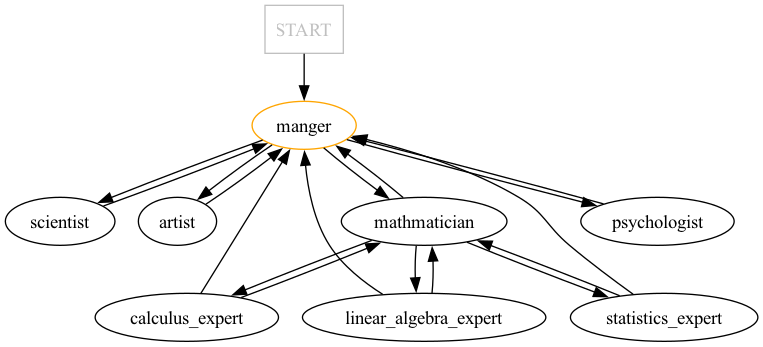

In [272]:
display(Image(g.draw_relations()))

handoff from manger to mathmatician
handoff from mathmatician to statistics_expert


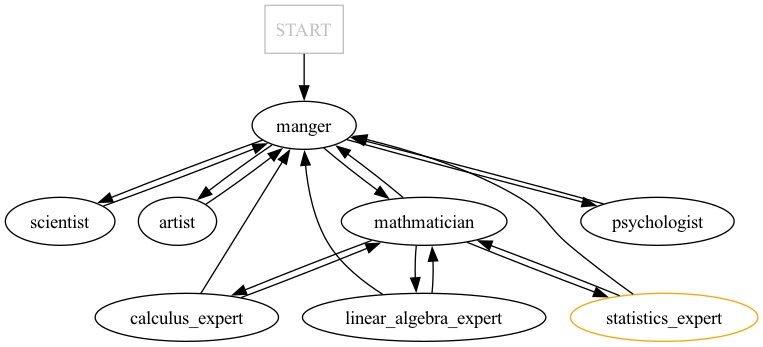

Calling agent statistics_expert to chat, this agent can be deployed anywhere
[{'role': 'assistant', 'content': "Statistics plays a critical role in our daily lives, influencing a wide range of decisions and behaviors. Here are some practical examples of how statistics can be used in everyday situations:\n\n### 1. **Budgeting and Personal Finance**\n   - **Example:** You can analyze your spending habits by categorizing expenses (e.g., groceries, entertainment, bills). By calculating the average amount spent in each category, you can identify areas where you might want to cut back to save money.\n\n### 2. **Health and Fitness**\n   - **Example:** Track your daily calorie intake and physical activity. By collecting this data over time and calculating the average calories consumed and burned, you can make more informed decisions about your diet and exercise routine. Additionally, you can analyze body metrics (weight, BMI) to assess health trends.\n\n### 3. **Cooking and Baking**\n   - **Ex

In [273]:
messages = "how to use statistics to daily life show me some examples"
messages = [{"role": "user", "content": messages}]
agent = g.handoff(messages)
display(Image(g.draw_relations()))
response = call_agent(agent, messages)
print(response)

handoff from statistics_expert to manger
handoff from manger to psychologist


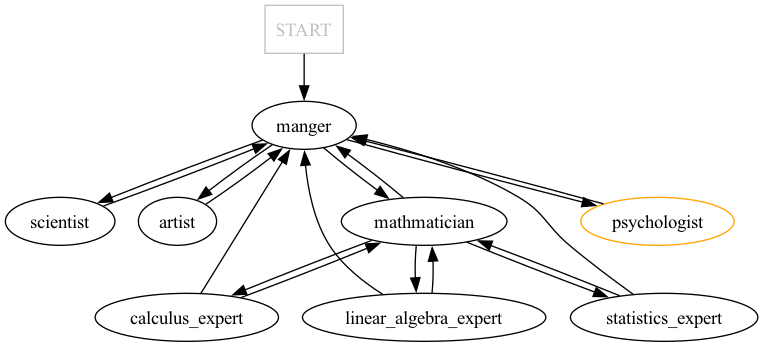

Calling agent psychologist to chat, this agent can be deployed anywhere
[{'role': 'assistant', 'content': "I'm sorry to hear that you're feeling this way. It's important to acknowledge your feelings. Sadness is a natural and common emotion that everyone experiences from time to time. It can arise from various situations, such as loss, disappointment, or even stress.\n\nIf you feel comfortable, talking about what's making you sad can sometimes help. Additionally, engaging in activities that you enjoy, reaching out to friends or family, or practicing self-care can also be beneficial. If your sadness persists or feels overwhelming, it may be helpful to consider speaking with a mental health professional who can provide support and guidance.", 'sender': 'psychologist'}]


In [274]:
messages = "I feel sad."
messages = [{"role": "user", "content": messages}]
agent = g.handoff(messages)
display(Image(g.draw_relations()))
response = call_agent(agent, messages)
print(response)

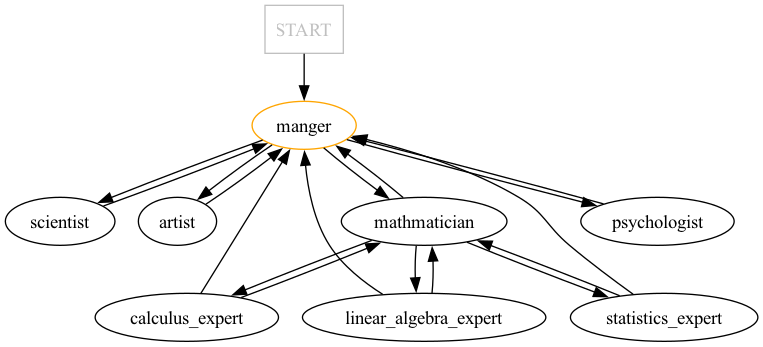

In [276]:
g.reset()
display(Image(g.draw_relations()))